## Configuração do Ambiente Simplificado
Assegure-se de que o dataset `comments_dataset_pt_improved.csv` está na mesma pasta deste notebook.

Execute esta célula para instalar as versões compatíveis das bibliotecas necessárias:
```bash
%pip install --upgrade --force-reinstall "numpy<2" pandas nltk scikit-learn matplotlib wordcloud
```

In [1]:
# Imports e setup
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download de stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grosa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Carrega dataset
df = pd.read_csv('../data/comments_dataset_pt_improved.csv')
df.head()

,id,plataforma,usuario,timestamp,comentario
0,1,Instagram,user11,2025-06-13 15:07:08,Excelente post!
1,2,Instagram,user170,2025-06-27 14:33:29,"Ótimas referências e fontes, obrigada!"
2,3,Instagram,user132,2025-07-01 18:26:10,Incrível!
3,4,Instagram,user161,2025-06-17 03:02:37,"Exemplo muito prático, gostei!"
4,5,Instagram,user50,2025-06-07 16:29:23,Adorei!


In [3]:
# Stop-words em Português
stopwords_pt = stopwords.words('portuguese')

In [4]:
# 1. Análise de Frequência de Termos (Keyword Analysis)
cv = CountVectorizer(stop_words=stopwords_pt)
dtm = cv.fit_transform(df['comentario'])
freq = dtm.sum(axis=0).A1
terms = cv.get_feature_names_out()
top10 = sorted(zip(terms, freq), key=lambda x: x[1], reverse=True)[:10]
import pandas as pd
pd.DataFrame(top10, columns=['Termo','Frequência'])

,Termo,Frequência
0,post,43
1,excelente,35
2,incrível,31
3,interessante,30
4,adorei,27
5,sensacional,27
6,gostei,26
7,obrigado,26
8,conteúdo,25
9,ajudou,24


In [5]:
# 2. TF-IDF
tfidf_vec = TfidfVectorizer(stop_words=stopwords_pt)
tfidf = tfidf_vec.fit_transform(df['comentario'])
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=tfidf_vec.get_feature_names_out())
df_tfidf.iloc[0].sort_values(ascending=False).head(5)

excelente    0.726897
post         0.686747
aborda       0.000000
reais        0.000000
prática      0.000000
Name: 0, dtype: float64

In [6]:
# 3. Análise de Sentimento (léxico simples)
positivos = {'ótimo','excelente','adorei','incrível','sensacional','útil','top','fantástico','perfeito'}
negativos = {'ruim','péssimo','problema','lento','difícil','insuportável','chato'}
def pontuar(texto):
    tokens = texto.lower().split()
    return sum(t in positivos for t in tokens) - sum(t in negativos for t in tokens)
df['sentiment_score'] = df['comentario'].apply(pontuar)
df[['comentario','sentiment_score']].head(10)

,comentario,sentiment_score
0,Excelente post!,1
1,"Ótimas referências e fontes, obrigada!",0
2,Incrível!,0
3,"Exemplo muito prático, gostei!",0
4,Adorei!,0
5,Boa dica!,0
6,Pode explicar melhor?,0
7,Adorei especialmente a forma como você explico...,1
8,Muito bom 😊,0
9,Incrível!,0


In [7]:
# 4. Modelagem de Tópicos (LDA)
lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda.fit(dtm)
topics = [(f'Tópico {i+1}', [terms[j] for j in comp.argsort()[-5:]]) for i, comp in enumerate(lda.components_)]
import pandas as pd
pd.DataFrame(topics, columns=['Tópico','Termos'])

,Tópico,Termos
0,Tópico 1,"[ótimo, ajudou, sensacional, incrível, post]"
1,Tópico 2,"[exemplos, gostei, adorei, interessante, excel..."


In [8]:
# 5. Similaridade de Texto (cosine similarity entre 1º e 2º comentário)
sim = cosine_similarity(tfidf[0], tfidf[1])[0][0]
sim

0.0

In [9]:
# 6. Reconhecimento de Entidades Nomeadas (RegEx simples)
def extract_entities(text):
    # Encontra palavras iniciando com letra maiúscula (aproximação)
    return re.findall(r"\b[A-ZÀ-Ú][a-zà-ú]+\b", text)
entities = df['comentario'].head(5).apply(extract_entities)
entities

0    [Excelente]
1       [Ótimas]
2     [Incrível]
3      [Exemplo]
4       [Adorei]
Name: comentario, dtype: object

In [10]:
# 7. Codificação Qualitativa de Dados
def categorizar(texto):
    txt = texto.lower()
    if 'tutorial' in txt or 'dica' in txt:
        return 'Dicas'
    if 'ótimo' in txt or 'excelente' in txt:
        return 'Elogio'
    return 'Outro'
df['categoria'] = df['comentario'].apply(categorizar)
df['categoria'].value_counts()

categoria
Outro     402
Elogio     59
Dicas      39
Name: count, dtype: int64

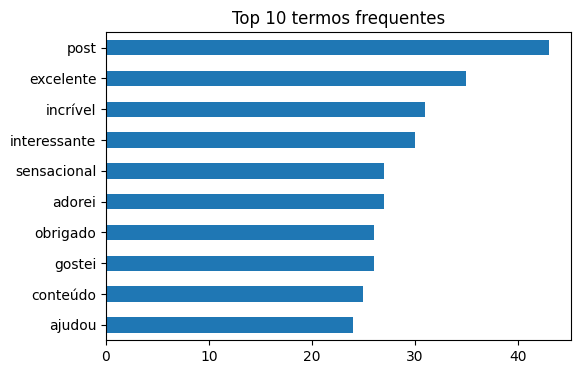

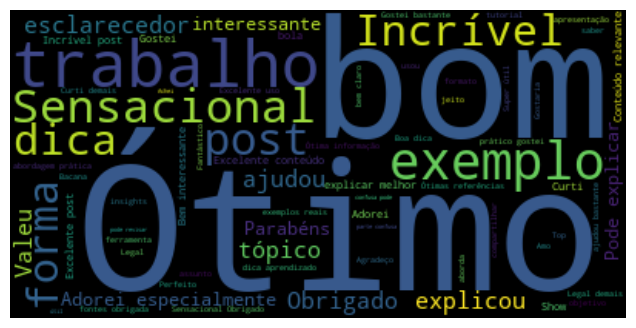

In [11]:
# 8. Visualização de Dados de Texto
pd.Series(dict(top10)).sort_values().plot.barh(figsize=(6,4), title='Top 10 termos frequentes')
plt.show()

wc = WordCloud(width=400, height=200, stopwords=set(stopwords_pt))
wc.generate(' '.join(df['comentario']))
plt.figure(figsize=(8,4))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()